In [1]:
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pandas as pd
import cv2
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from tqdm import tqdm

In [2]:
import seaborn as sns

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from IPython.core.display import clear_output
!unzip '/content/drive/MyDrive/Colab_Notebooks/lab3dataset.zip' -d 'lab3dataset'
clear_output()

In [6]:
df = pd.read_csv("/content/lab3dataset/train.csv",low_memory = False)
# To display the top 5 rows
df.head(5)

,image,Class
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106


In [7]:
print(sorted(df['Class'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196]


In [8]:
class Dataset():
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = "/content/lab3dataset/dataset/" + self.df.iloc[idx, 0]
        image = cv2.imread(path)
        label = self.df.iloc[idx, 1] -1 #reduce value of classes by 1 couse lables starts from 0 in dataset
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = torch.tensor(label)
        return image, label

In [69]:
image_transforms = transforms.Compose([
    # transforms.ToTensor(),
                                        transforms.ToPILImage(),
                                        transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # was 256*256
                                        transforms.CenterCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        # transforms.ToTensor(),
                                        transforms.RandomRotation([-30, 30]),
                                        # transforms.ToPILImage(),
                                        transforms.RandomEqualize(),
                                        transforms.RandomAutocontrast(),
                                        # transforms.RandomGrayscale(0.1),
                                        # transforms.RandomAffine([0,10]),
                                        # transforms.AutoAugment(),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

                                      ])

Total: 7000


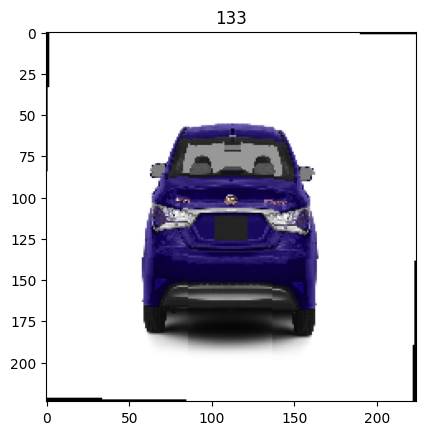

In [72]:
dataset = Dataset(df = df, transform = image_transforms, target_transform = True)
# get len dataset
print(f'Total: {dataset.__len__()}')
# show 1th-image and label
img, label = dataset.__getitem__(3)

plt.imshow(img.permute(1, 2, 0))
plt.title(label.item())
plt.show()

In [73]:
train_count = int(0.9*len(dataset))
test_count = len(dataset)-train_count
train_set, test_set = random_split(dataset, [train_count, test_count])

train_size = int(0.9*train_count)
val_size = train_count-train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

print('dataset len: ', dataset.__len__())
print('train set: ', train_set.__len__())
print('val set: ', val_set.__len__())
print('test set: ', test_set.__len__())

dataset len:  7000
train set:  5670
val set:  630
test set:  700


In [74]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [75]:
# from torchvision.models.resnet import ResNet50
# import torchvision.models as models
# # model = models.alexnet(pretrained=True)
# model = models.efficientnet_b0(pretrained=True)
# for params in model.parameters():
#             params.requires_grad = False

# model.to(device);

# from torchvision.models import efficientnet
# model = efficientnet.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
# model.classifier[1] = nn.Linear(1280, 196)
# model.to(device);
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(2048, 196)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 325MB/s]


In [76]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
from torchinfo import summary
summary(model,input_size=(1, 3, 224, 224)) #1,3,244,244

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 196]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [ ]:
# # model.classifier[6] = nn.Linear(4096, 196)
# model.classifier[1] = nn.Linear(1280, 196)
# # print(model.classifier[6])
# summary(model,input_size=(1, 3, 224, 224)) #1,3,256,256

In [78]:
from torch import optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [79]:
!pip install pytorch.ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 11.0 MB/s eta 0:00:00


In [80]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [81]:
# Число эпох
epochs = 7
# Движки trainer, evaluator
trainer = create_supervised_trainer(model, optimizer, loss_fn, device = device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(loss_fn),
    'cm':ConfusionMatrix(num_classes=196)
}
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device = device)
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [82]:
def score_function(engine):
    test_loss = engine.state.metrics['nll']
    return -test_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
test_evaluator.add_event_handler(Events.COMPLETED, handler)

In [83]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

trainer.add_event_handler(Events.EPOCH_COMPLETED, log_test_results)

In [84]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = range(196)

    fig, ax = plt.subplots(figsize=(300,300))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

In [85]:
to_save = {'model': model}
handler = Checkpoint(
    to_save, './models_lab3_15',
    n_saved=1, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, handler)


In [86]:
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.10/dist-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [87]:
trainer.run(train_loader, max_epochs=epochs)

Output hidden; open in https://colab.research.google.com to view.

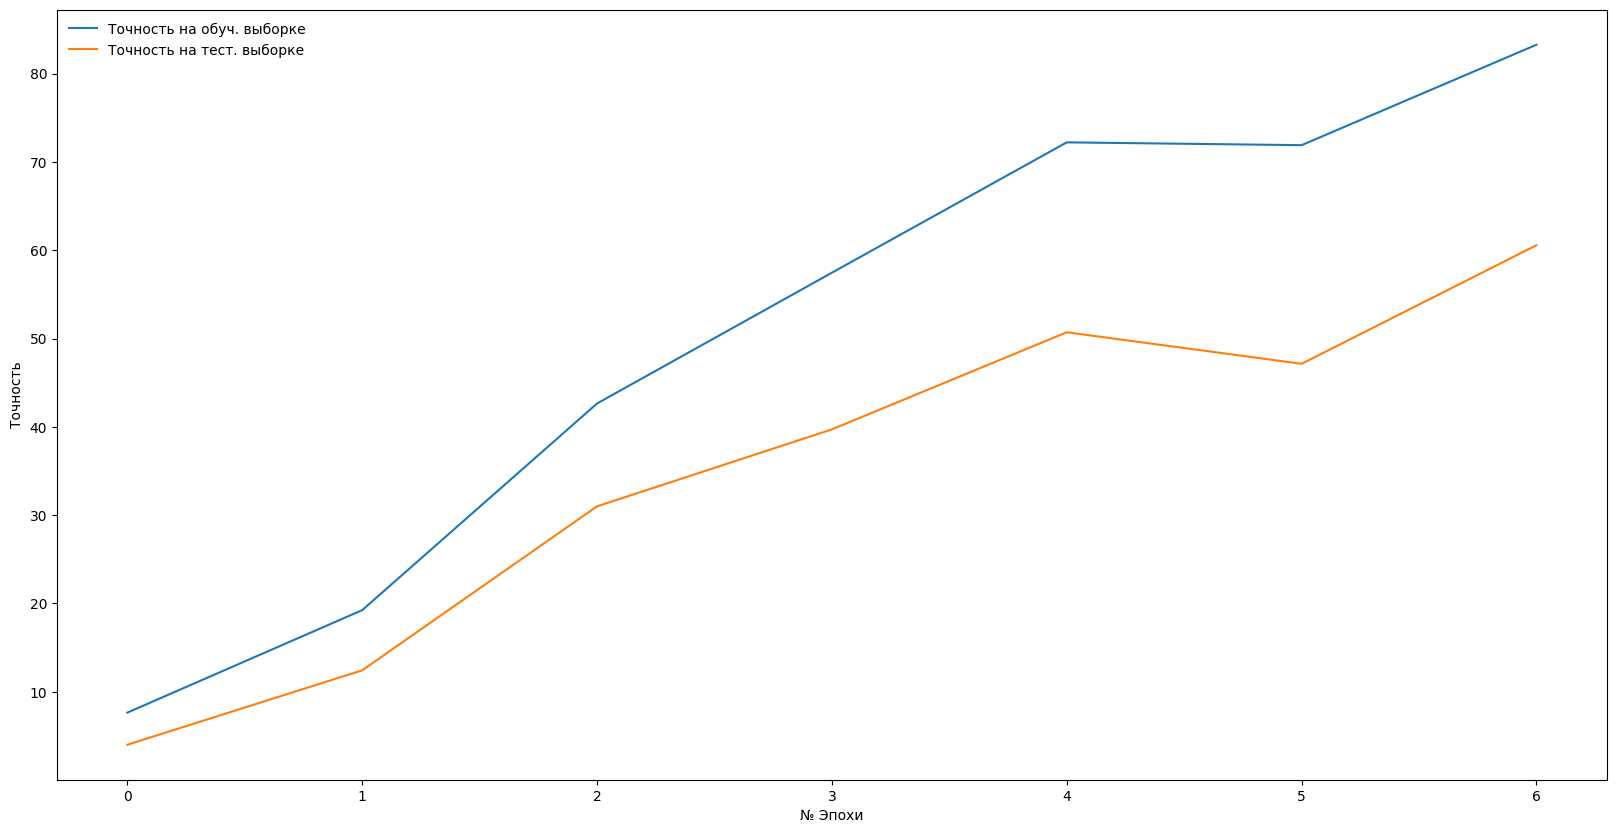

In [59]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

In [88]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')

In [ ]:
# log_confusion_matrix(trainer)

In [ ]:
# classes = sorted(df['Class'].unique())
# for i in range(0, classes):
#   classes[i] = i


# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data.to(device)
#         outputs = model(images)
#         _, predictions = torch.max(outputs, 1)
#         # собираем правильные прогнозы для каждого класса
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # Выводим точность на каждом классе
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5f} is {accuracy:.1f} %')

In [ ]:
#under one from artem

In [ ]:
# train_losses=[]
# train_acc=[]
# def train(model,epoch):
#     print('\nEpoch : %d'%epoch)
#     model.train()
#     running_loss=0
#     correct=0
#     total=0
#     for data in tqdm(train_loader):
#         inputs,labels=data[0].to(device),data[1].to(device)
#         labels = labels.type(torch.LongTensor)
#         labels = labels.to(device)
#         labels = labels.squeeze()
#         optimizer.zero_grad()
#         outputs=model(inputs)
#         outputs.squeeze
#         loss=loss_fn(outputs,labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
#     train_loss=running_loss/len(train_loader)
#     acc=100.*correct/total
#     train_acc.append(acc)
#     train_losses.append(train_loss)
#     print('Train Loss per epoch: %.4f | Train Accuracy per epoch: %.4f'%(train_loss,acc))

In [ ]:
# val_losses=[]
# val_acc=[]
# def test(model,epoch):
#     print('\nEpoch : %d'%epoch)
#     model.eval()
#     running_loss=0
#     correct=0
#     total=0
#     with torch.no_grad():
#         for data in tqdm(test_loader):

#             inputs,labels=data[0].to(device),data[1].to(device)
#             labels = labels.type(torch.LongTensor)
#             labels = labels.to(device)
#             labels = labels.squeeze()
#             outputs=model(inputs)
#             outputs.squeeze
#             loss=loss_fn(outputs,labels)

#             running_loss += loss.item()

#             _, predicted = outputs.max(1)

#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()
#         val_loss=running_loss/len(train_loader)
#         acc=100.*correct/total
#         val_acc.append(acc)
#         val_losses.append(val_loss)
#         print('Val Loss per epoch: %.4f | Val Accuracy per epoch: %.4f'%(val_loss,acc))

In [ ]:
# max_epochs=10
# for epoch in range(1,max_epochs+1):
#     train(model,epoch)
#     test(model,epoch)

In [ ]:
# max_epochs=10
# for epoch in range(11,21):
#     train(model,epoch)
#     test(model,epoch)

In [ ]:
# plt.plot(train_acc,label = "train_acc")
# plt.plot(val_acc,label = "val_acc")
# plt.legend()
# plt.show()

# plt.plot(val_losses,label = "train_losses")
# plt.plot(val_losses,label = "val_losses")
# plt.legend()
# plt.show()

In [ ]:
# model_scripted = torch.jit.script(model)
# model_scripted.save('model_scripted.pt')